# Tite-seq modeling

## Set up analysis

In [1]:
import yaml
# Immediatly Force JAX to use CPU
with open('config.yaml') as f:
    config = yaml.safe_load(f)

import os
import glob
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count=1 --xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1'

import warnings
warnings.simplefilter('ignore')

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit
import jaxopt

import numpy as np
import scipy
import pandas as pd
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import fcsparser


## Data

Define concentrations and bins

In [2]:
concs = np.array(config['concentrations']['CGG']).astype(float)
b = np.array(config['bins']['CGG'])
bins = np.array(range(1, len(b)))
bins, b

(array([1, 2, 3, 4]),
 array([-2.88000e+02,  1.36000e+02,  2.00000e+03,  2.94210e+04,
         2.62143e+05]))

Load variant counts file

In [3]:
df_variants = pd.read_csv(config['prepped_variant_counts_file']).query(f"sample.str.contains('TiteSeq')")

## Model elaborations



### Latent fluorescence

We sort cells at 9 concentrations $x_1, \ldots, x_9$.
For a cell of variant $i$, model the fluorescence $z_i$ at each concentration $x_j$ with a log-normal distribution:
$$
\log z_i\mid x_j \sim \mathcal{N}\left(\log f(x_i; \kappa_i, \alpha_i), \ σ^2\right),
$$
with median given by an affine function of antigen occupancy of the cell, which obeys Hill-Langmuir kinetics.
$$
f(x_j; \alpha_i, \beta, \kappa_i) = \alpha_i\left(\frac{x_j}{x_j + \kappa_i}\right) + \beta,
$$
where $\kappa_i$ is the dissociation constant ($K_D$) of variant $i$, $\alpha_i$ models the maximum fluorescence at saturation of variant $i$ (a function of the variant's surface expression of antibody), $\beta$ models a cell autofluorescence baseline, and $\sigma^2$ is the variance profile on the log-fluorescence scale.

### Fluorescence bins

We sort cells into 4 fluorescence bins, defined by the right-open intervals bounded by $b_0=0, b_1, b_2, b_3, b_4=\infty$.
The probability that a cell from variant $i$ sorted at concentration $x_j$ appears within a fluorescence bin defined by the interval $[b_{k-1}, b_k)$ is obtained by integrating the log-normal distribution over the bin interval:
$$
p_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) = \Phi\left(\frac{\log b_k - \log f(x_j; \kappa_i, \alpha_i)}{\sigma}\right) - \Phi\left(\frac{\log b_{k-1} - \log f(x_j; \alpha_i, \beta, \kappa_i)}{\sigma}\right),
$$
where $\Phi$ is the CDF of the standard normal distribution.

### Compound counting process for cells and reads

Let parameter $\rho_i$ denote the library fraction of variant $i$.
We know the total number of cells $C_{jk}$ sorted at concentration $x_j$ and fluorescence bin $k$, so (by the Poissonization theorem) the number of cells of variant $i$ sorted at concentration $x_j$ and fluorescence bin $k$ is a random variable $C_{ijk}\sim\mathrm{Pois}(C_{jk} \rho_i p_{ijk})$. 

We additionally know the total number of reads $R_{jk}$ sequenced from cells sorted at concentration $x_j$ and fluorescence bin $k$. Conditioning on the number of cells $C_{ijk}$, the number of reads of variant $i$ sequenced from cells sorted at concentration $x_j$ and fluorescence bin $k$ is a random variable $Y_{ijk}\mid C_{ijk} \sim \mathrm{Pois}(R_{jk} C_{ijk})$.
The unconditional $Y_{ijk}$ is a compound Poisson random variable:
$$
Y_{ijk} = \sum_{\ell=1}^{C_{ijk}} Q_{ijk}^{(\ell)},
$$
where $Q_{ijk}^{(\ell)}\sim\mathrm{Pois}\left(\frac{R_{jk}}{C_{jk}}\right)$ is the number of reads from cell $\ell$ of variant $i$ sorted at concentration $x_j$ and fluorescence bin $k$.

The PMF for $Y_{ijk}$ is intractable, but we expect it will look like an over-dispersed Poisson distribution.
This motivates an approximation of $Y_{ijk}$ as a negative binomial random variable, with moments matched to the compound Poisson random variable, which are tractable.
Denote the Poisson intensity of cells of variant $i$ sorted at concentration $x_j$ and fluorescence bin $k$ as
$$
\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) := C_{jk} \rho_i p_{ijk}(\alpha_i, \beta, \kappa_i, \sigma),
$$
and the Poisson intensity of reads per cell (read depth) at concentration $x_j$ and fluorescence bin $k$ as
$$
D_{jk} := \frac{R_{jk}}{C_{jk}}.
$$
After some calculation for the moments, we find the approximation
$$
Y_{ijk} \sim \mathrm{NB}\left(\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma), \frac{D_{jk}}{D_{jk} + 1}\right).
$$

### Likelihood

The log-likelihood given read count data tensor $Y\in\mathbb{N}^{n\times 9\times 4}$ is then
$$
\log \mathcal{L}(\boldsymbol\alpha, \beta, \boldsymbol\kappa, \sigma; Y) = \sum_{i=1}^n \sum_{j=1}^9 \sum_{k=1}^4 \left(\log\gamma(\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) + Y_{ijk}) - \log\gamma(\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma)) + \lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) \log\left(\frac{D_{jk}}{D_{jk} + 1}\right)\right),
$$
where $\gamma$ denotes the gamma function.

### Constrained optimization

We must constrain the parameters to ensure that the predicted aggregate fluorescence of all variants matches the empirical FACS data.
We use the [augmented Lagrangian method](https://epubs.siam.org/doi/book/10.1137/1.9781611973365) with a generalized Kullback-Leibler divergence constraint on the aggregate fluorescence.
The constraint function is... **TODO**

## FACS data

In [4]:
fcs_files = sorted(glob.glob(config['facs_file_pattern']))
fcs_files

['exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_001_P4_006.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_002_P4_007.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_003_P4_008.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_004_P4_009.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_005_P4_010.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_006_P4_011.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_007_P4_012.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_008_P4_013.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_009_P4_014.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_010_P4_015.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_011_P4_016.fcs',
 'exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_012_P4_017.fcs',
 'exptl_data/210624_TiteSeq_

In [5]:
fcs_df = pd.DataFrame()

pe_grid = np.logspace(np.log10(b[1]) - 2, np.log10(b[-1]), 25)
logf_grid = np.log(pe_grid)

logf_pdfs1 = np.full((len(concs), len(logf_grid)), np.nan)
logf_pdfs2 = np.full((len(concs), len(logf_grid)), np.nan)

for fcs_file in fcs_files:
    title_str = fcs_file.split("/")[-1].split(".")[0]
    sample_number = int(title_str.split("_")[3])
    library = (sample_number - 1) // len(concs) + 1
    meta, fcs = fcsparser.parse(fcs_file, reformat_meta=True)
    spill_values = meta["SPILL"].split(',')
    n_ch = int(spill_values[0])
    spill_df = pd.DataFrame(np.array(spill_values[(n_ch + 1):], dtype=np.float64).reshape((n_ch, n_ch)).T,
                            index=spill_values[1:(n_ch + 1)])
    fcs[spill_df.index] = np.linalg.solve(spill_df, fcs[spill_df.index].T).T
    fcs["sample"] = title_str
    concentration_idx = sample_number % len(concs) - 1
    fcs["library"] = library
    fcs["concentration"] = concs[concentration_idx]
    fcs_df = pd.concat(
        (fcs_df,
            fcs[["library",
                "sample",
                "concentration",
                "PE-A",
                ]
                ]
            ),
            ignore_index=True)
    
    # fcs["PE-A"] = np.clip(fcs["PE-A"], b[0], b[-1])

    not_truncated_idxs = np.where((fcs["PE-A"] > 0) & (fcs["PE-A"] < b[-1]))[0]
    kde = scipy.stats.gaussian_kde(
        np.log(fcs["PE-A"].values[not_truncated_idxs]),
        bw_method=.1)
    truncated_fraction = (fcs["PE-A"] >= b[-1]).sum() / len(fcs)
    if library == 1:
        logf_pdfs1[concentration_idx, :] = kde(logf_grid) #/ jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)
    else:
        logf_pdfs2[concentration_idx, :] = kde(logf_grid) #/ jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)

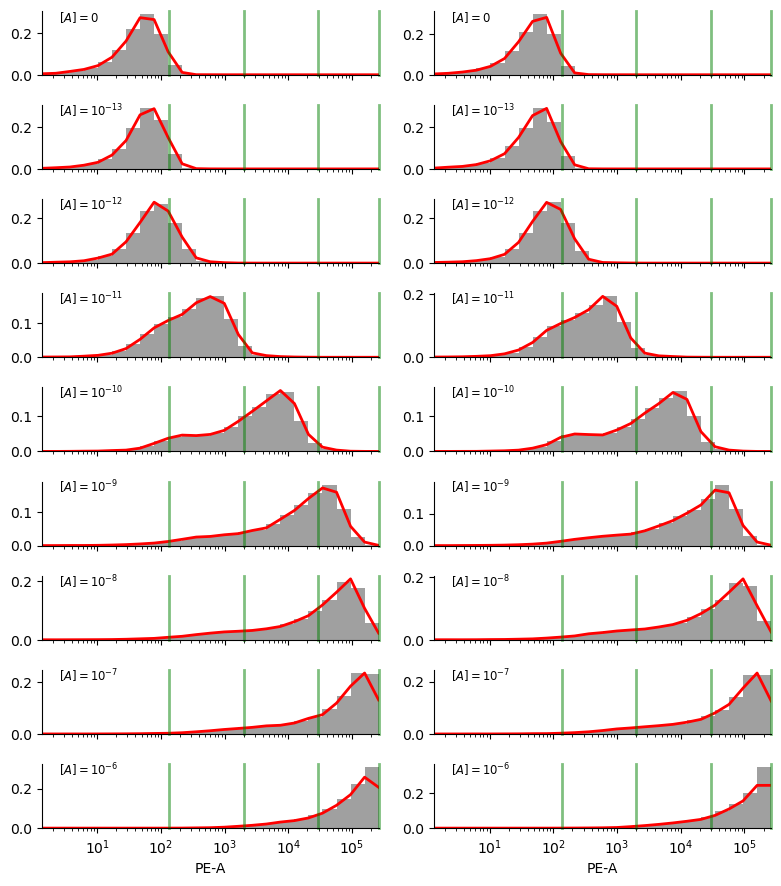

In [6]:
g = sns.displot(
    data=fcs_df.loc[(fcs_df["PE-A"] >= np.exp(logf_grid)[0]) & (fcs_df["PE-A"] <= np.exp(logf_grid)[-1])],
    x="PE-A",
    row="concentration",
    col="library",
    bins=np.exp(logf_grid),
    # bins=np.concatenate((np.linspace(fcs_df["PE-A"].min(), 0, 10), np.logspace(1, 6, 100))),
    # bins=fcs_df["PE-A"].min() + np.logspace(1, 6, 100),
    # stat="frequency",
    stat="probability",
    common_norm=False,
    color="gray",
    height=1, aspect=4,
    facet_kws=dict(sharey=False),
    )

g.set_ylabels("")
g.set_titles("")

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i, j].plot(np.exp(logf_grid),
                          (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :] / (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :].sum(),
                          color="r", lw=2)
        for bi in b[1:]:
            g.axes[i, j].axvline(bi, color="g", clip_on=False, alpha=0.5, lw=2)
            if g.row_names[i] > 0:
                power = int(np.log10(g.row_names[i]))
                title = f"$[A] = 10^{{{power}}}$"
            else:
                title = "$[A] = 0$"
            g.axes[i, j].set_title(title,
                        fontsize='small',
                        loc='left',
                        x=0.05,
                        y=0.7,
                        )

plt.xscale("log")
plt.xlim(np.exp(logf_grid[0]), np.exp(logf_grid[-1]))
plt.tight_layout()

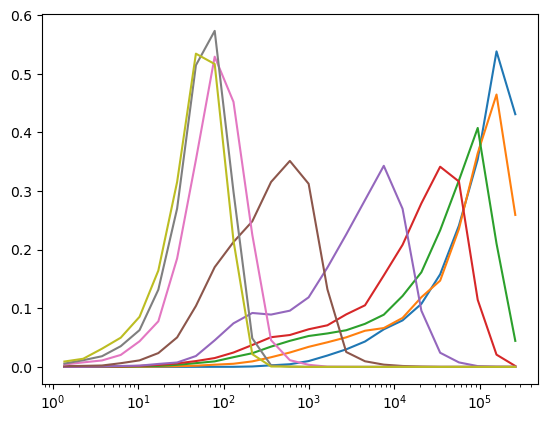

In [7]:
plt.plot(np.exp(logf_grid), logf_pdfs1.T)
plt.xscale("log")

In [8]:
fcs_df["PE-A"] < b[0]

0         False
1         False
2         False
3         False
4         False
          ...  
351067    False
351068    False
351069    False
351070    False
351071    False
Name: PE-A, Length: 351072, dtype: bool

In [9]:
meta, data = fcsparser.parse(fcs_file, reformat_meta=True)

spill_values = meta["SPILL"].split(',')
n = int(spill_values[0])  # The first item is the number of channels
spill_df = pd.DataFrame(np.array(spill_values[3:], dtype=np.float64).reshape((n, n)).T,
                        index=spill_values[1:3],
                        columns=spill_values[1:3])
spill_df


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


In [10]:
with pd.option_context("display.precision", 10):
    print("spillover matrix")
    display(spill_df)
    print("inverse spillover matrix")
    display(pd.DataFrame(np.linalg.inv(spill_df), index=spill_df.columns, columns=spill_df.columns))

spillover matrix


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


inverse spillover matrix


,PE-A,FITC-A
PE-A,1.0000255007,-0.0030000765
FITC-A,-0.0085002168,1.0000255007


Spillover matrix mixes two true signals into two observed signals:
$$
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
$$
So to recover the true signals from the observed signals, we invert the matrix:
$$
\begin{align*}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
&=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}\\
&=
\begin{pmatrix}
1.0000255007 & -0.0030000765 \\
-0.0085002168 & 1.0000255007 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
\end{align*}\\
$$

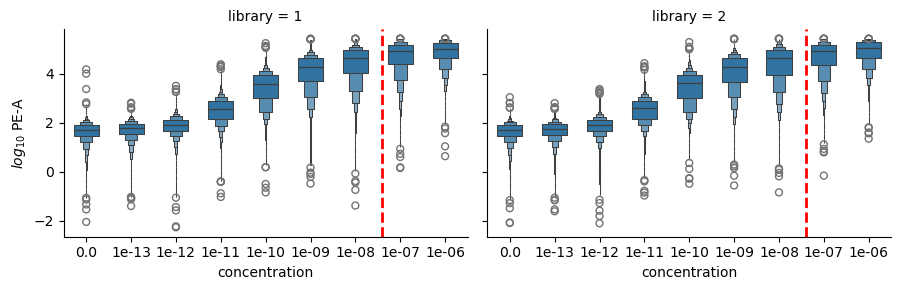

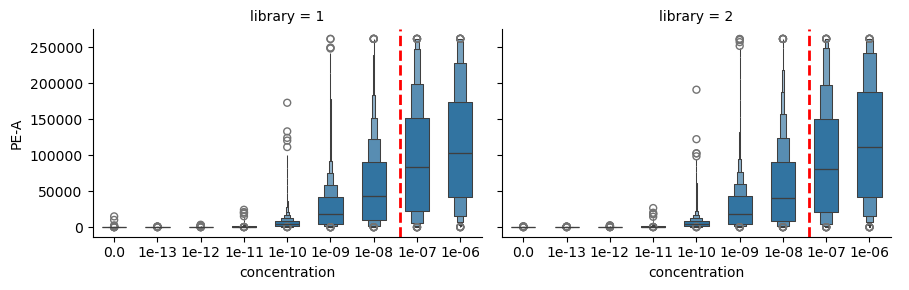

In [11]:
fcs_df["$log_{10}$ PE-A"] = np.log10(fcs_df["PE-A"])
for yval in ("$log_{10}$ PE-A", "PE-A"):
    g = sns.catplot(data=fcs_df,
                    kind="boxen",
                    col="library",
                    x="concentration",
                    y=yval,
                    gap=.3,
                    height=3, aspect=1.5,
                )
    g.refline(x=6 + np.log10(4), color="r", linestyle='--', lw=2, label="BLI naive $K_D$")
    plt.tight_layout()
    plt.show()

In [12]:
logf_pdfs1 = np.flip(logf_pdfs1, axis=0)
logf_pdfs2 = np.flip(logf_pdfs2, axis=0)

### Modeling functions

In [13]:
# NOTE: assumes logx[0] = -inf
def f(logx, logα, logβ, logKd, logn):
    n = jnp.exp(logn)  # Hill coefficient
    logx = jnp.atleast_1d(logx)[:, None]
    logα = jnp.atleast_1d(logα)[None, :]
    logKd = jnp.atleast_1d(logKd)[None, :]
    result = jnp.exp(logβ) * jnp.ones((logx.shape[0], logα.shape[-1]))
    result = result.at[1:].add(jnp.exp(logα) * jexpit(n * (logx[1:] - logKd))).squeeze()
    return result

# NOTE: this function assumes truncation on the high bin, so all counts above it are in that bin (infinite upper boundary)
def logp(logx, logα, logβ, logKd, b, logσ, logn):
    fs = f(logx, logα, logβ, logKd, logn)
    σ = jnp.exp(logσ)
    logcdf_points = jax.scipy.stats.norm.logcdf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    logsf_points = jax.scipy.stats.norm.logsf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    first = logcdf_points[:, 0, None]
    middle = jax.scipy.special.logsumexp(jnp.concatenate((logcdf_points[:, 1:, None], logcdf_points[:, 0:-1, None]),
                                                       axis=-1),
                                       b=jnp.array([1, -1]),
                                       axis=-1)
    # this accounts for the fact that the last bin includes all values above the last boundary
    last = logsf_points[:, -1, None]
    return jnp.concatenate((first, middle, last), axis=-1)     

def p(logx, logα, logβ, logKd, b, logσ, logn):
    return jnp.exp(logp(logx, logα, logβ, logKd, b, logσ, logn))

@jax.jit
def one_neg_log_likelihood(logγ, logα, logKd, y, logβ, logσ, logx, b, cells, reads_per_cell, logn):
    # We have a compound poisson distribution for the read count in each (concentration, bin)
    # We match moments to the negative binomial distribution
    logp_ = logp(logx, logα, logβ, logKd, b, logσ, logn)
    # expected cell count matrix
    λ_cell = cells[:, None] * jnp.exp(logγ + logp_[None, :])
    nbinom_logp = - jnp.log1p(reads_per_cell)
    
    ll = jax.scipy.special.gammaln(λ_cell + y) - jax.scipy.special.gammaln(λ_cell) + λ_cell * nbinom_logp

    return -ll.sum()

vmap_one_neg_log_likelihood = jax.vmap(one_neg_log_likelihood, in_axes=(0, 0, 0, 0, None, None, None, None, None, None, None))

@jax.jit
def DKL(params, data):
    logγs, logαs, logKds, logσ, logn = params
    Y, wt_idx, logx, b, cells, reads_per_cell, logβ, logf_grid, logf_pdfs, single_mut_idxs, other_mut_idxs = data
    σ = jnp.exp(logσ)
    fs = f(logx, logαs, logβ, logKds, logn)
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    return jax.scipy.integrate.trapezoid(jax.scipy.special.kl_div(logf_pdfs, logf_pdfs_predicted), x=logf_grid, axis=1).sum()

@jax.jit
def neg_log_likelihood(params, data,
                       μ=0.0,  # prior matching weight
                       λ=0.0,  # Lagrange multiplier estimate for Augmented Lagrangian iterates
                       γ_ridge=0.0, α_ridge=0.0, Kd_ridge=0.0,
                       ):
    logγs, logαs, logKds, logσ, logn = params
    Y, wt_idx, logx, b, cells, reads_per_cell, logβ, logf_grid, logf_pdfs, single_mut_idxs, other_mut_idxs = data
    logγs = logγs * jnp.ones(Y.shape[0])
    logαs = logαs * jnp.ones(Y.shape[0])
    logKds = logKds * jnp.ones(Y.shape[0])
    
    nll = vmap_one_neg_log_likelihood(logγs, logαs, logKds, Y, logβ, logσ, logx, b, cells, reads_per_cell, logn).mean()

    D = DKL(params, data)
    prior_penalty = (μ / 2) * D ** 2 + λ * D

    logγ_penalty = γ_ridge * (((logγs[single_mut_idxs] - logγs[single_mut_idxs].mean()) ** 2).sum() + ((logγs[other_mut_idxs] - logγs[other_mut_idxs].mean()) ** 2).sum())
    # logα_nonwt_mean = (logαs.sum() - logαs[wt_idx]) / (len(logαs) - 1)
    # logα_penalty = α_ridge * (((logαs - logα_nonwt_mean) ** 2).sum() - ((logαs[wt_idx] - logα_nonwt_mean) ** 2).sum())
    # logKd_nonwt_mean = (logKds.sum() - logKds[wt_idx]) / (len(logKds) - 1)
    # logKd_penalty = Kd_ridge * (((logKds - logKd_nonwt_mean) ** 2).sum() - ((logKds[wt_idx] - logKd_nonwt_mean) ** 2).sum())
    logα_penalty = α_ridge * ((logαs - logαs[wt_idx]) ** 2).sum()
    logKd_penalty = Kd_ridge * ((logKds - logKds[wt_idx]) ** 2).sum()

    return nll + logγ_penalty + logα_penalty + logKd_penalty + prior_penalty


@jax.jit
def one_mean_bin_loss(logα, logKd, ynorm, logβ, logσ, logx, b, binfs,
                      ):
    mean_bin_dat = (ynorm * binfs).sum(1) / ynorm.sum(1)
    ps = p(logx, logα, logβ, logKd, b, logσ)
    mean_bin_model = (ps * binfs).sum(1) / ps.sum(1)
    w = jnp.log(ynorm.sum(-1, keepdims=True))
    # w = jnp.ones(Ynorm.shape[1])
    curve_fit_loss = (w * (mean_bin_model - mean_bin_dat) ** 2).sum()
    return curve_fit_loss

vmap_mean_bin_loss = jax.vmap(one_mean_bin_loss, in_axes=(0, 0, 0, None, None, None, None, None,
                                                          ))

@jax.jit
def mean_bin_loss(params, data,
                  prior_weight=0.0,
                #   L2_logα=0.0, L2_logKd=0.0,
                  ):
    logαs, logKds, logσ = params
    Ynorm, logx, b, binfs, logβ, logf_grid, logf_pdfs = data
    # Ynorm, logx, b, binfs, ref_idx = data
    logαs = logαs * jnp.ones(Ynorm.shape[0])
    logKds = logKds * jnp.ones(Ynorm.shape[0])

    curve_fit_loss = vmap_mean_bin_loss(logαs, logKds, Ynorm, logβ, logσ, logx, b, binfs,
                                        ).mean()
    # return curve_fit_loss
    # return (curve_fit_loss
    #         + L2_logα * ((logαs - logαs[ref_idx]) ** 2).mean()
    #         + L2_logKd * ((logKds - logKds[ref_idx]) ** 2).mean()
    #         )
    σ = jnp.exp(logσ)
    fs = f(logx, logαs, logβ, logKds)
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    logf_pdfs_predicted = logf_pdfs_predicted / jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1)[:, None]
    # plt.plot(logf_grid, logf_pdfs.T, c="C0")
    # plt.plot(logf_grid, logf_pdfs_predicted.T, c="C1")
    # plt.show()
    # print(jax.scipy.integrate.trapezoid(logf_pdfs, x=logf_grid, axis=1))
    # print(jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1))
    prior_loss = jax.scipy.integrate.trapezoid((logf_pdfs_predicted - logf_pdfs) ** 2, x=logf_grid, axis=1).sum()

    return curve_fit_loss + prior_weight * prior_loss


Read and cell count data

In [14]:
barcode_runs = pd.read_csv(config['barcode_runs']).drop(columns=["R1"])
barcode_runs.query("sample.str.startswith('TiteSeq')", inplace=True)
barcode_runs.set_index(["library", "sample"], inplace=True)
barcode_runs.concentration = concs[barcode_runs.concentration.astype(int) - 1]
print(barcode_runs.shape)
barcode_runs.head()

(72, 5)


sample_type  sort_bin  concentration    date  \
library sample                                                         
lib1    TiteSeq_01_bin1     TiteSeq         1   1.000000e-06  210624   
        TiteSeq_01_bin2     TiteSeq         2   1.000000e-06  210624   
        TiteSeq_01_bin3     TiteSeq         3   1.000000e-06  210624   
        TiteSeq_01_bin4     TiteSeq         4   1.000000e-06  210624   
        TiteSeq_02_bin1     TiteSeq         1   1.000000e-07  210624   

                         number_cells  
library sample                         
lib1    TiteSeq_01_bin1          9967  
        TiteSeq_01_bin2        100694  
        TiteSeq_01_bin3        910229  
        TiteSeq_01_bin4       4152079  
        TiteSeq_02_bin1         78772

In [15]:
R_df = df_variants.rename(columns={"antigen_concentration": "concentration",
                                   "read_count": "number_reads"}).groupby(["library", "concentration", "bin"]).number_reads.sum().sort_index()
C_df = barcode_runs.reset_index().rename(columns={"sort_bin": "bin"}).set_index(["library", "concentration", "bin"]).number_cells.sort_index()
assert C_df.index.equals(R_df.index)

counts_df = pd.concat((R_df, C_df), axis=1, verify_integrity=True)

counts_df

number_reads  number_cells
library concentration bin                            
lib1    0.000000e+00  1        10601523       4994518
                      2          100474         97766
                      3             243           156
                      4              38            57
        1.000000e-13  1         1884022       4879499
...                                 ...           ...
lib2    1.000000e-07  4         6040527       3595640
        1.000000e-06  1            1599          5023
                      2          138268         85666
                      3         1719136        910355
                      4         5039341       4087566

[72 rows x 2 columns]

Jax data from pandas frames

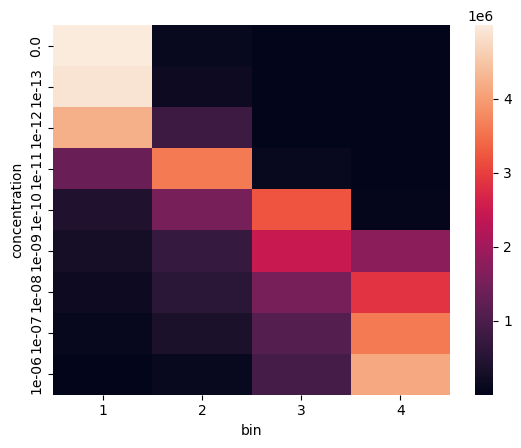

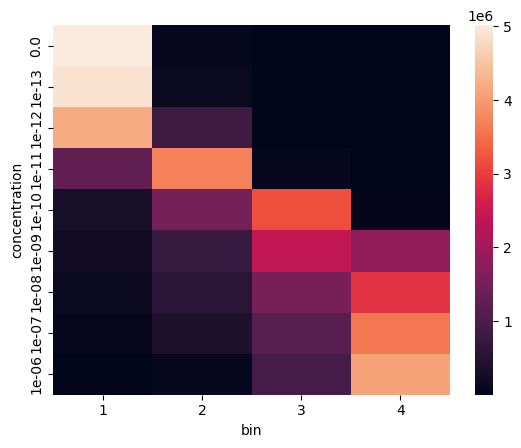

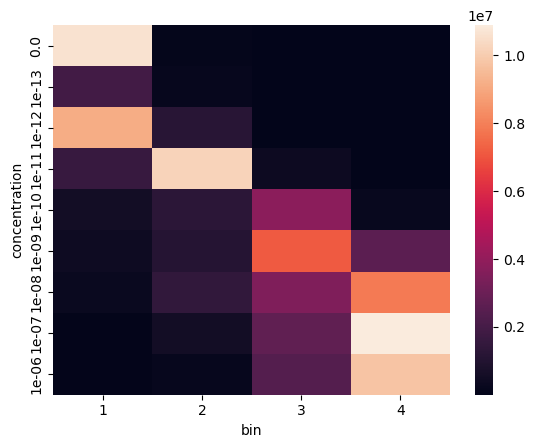

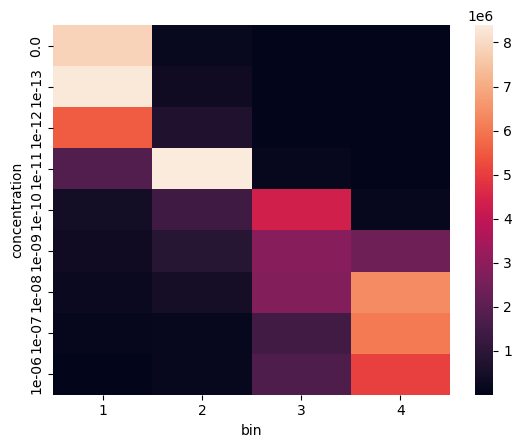

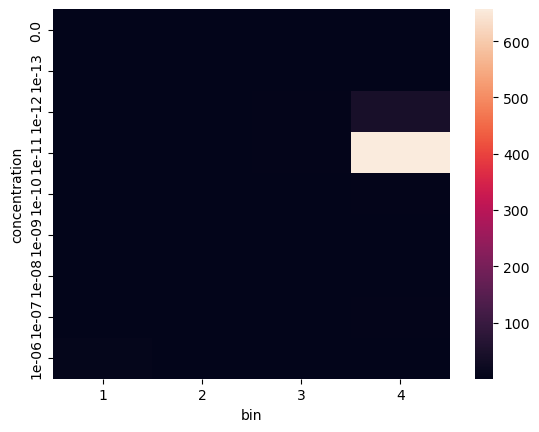

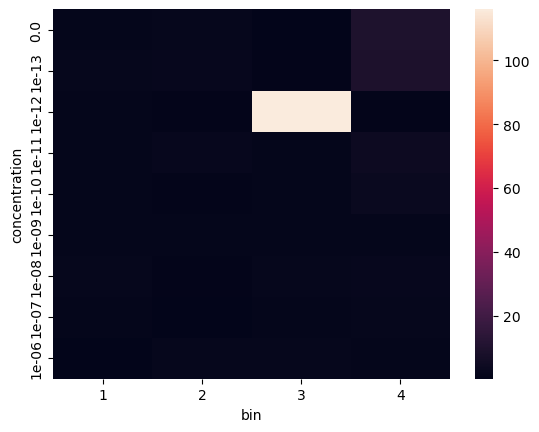

In [16]:
cells1 = counts_df.loc["lib1"].reset_index().pivot(index="concentration", columns="bin", values="number_cells")
cells2 = counts_df.loc["lib2"].reset_index().pivot(index="concentration", columns="bin", values="number_cells")

reads1 = counts_df.loc["lib1"].reset_index().pivot(index="concentration", columns="bin", values="number_reads")
reads2 = counts_df.loc["lib2"].reset_index().pivot(index="concentration", columns="bin", values="number_reads")

reads_per_cell1 = reads1 / cells1
reads_per_cell2 = reads2 / cells2

sns.heatmap(cells1)
plt.show()
# plt.savefig(f"{output}/cells1.pdf")
sns.heatmap(cells2)
plt.show()
# plt.savefig(f"{output}/cells2.pdf")

sns.heatmap(reads1)
plt.show()
# plt.savefig(f"{output}/reads1.pdf")
sns.heatmap(reads2)
plt.show()
# plt.savefig(f"{output}/reads2.pdf")

sns.heatmap(reads_per_cell1)
plt.show()
# plt.savefig(f"{output}/reads_per_cell1.pdf")
sns.heatmap(reads_per_cell2)
plt.show()
# plt.savefig(f"{output}/reads_per_cell2.pdf")

In [17]:
x = np.flip(concs)
logx = np.log(x)
libs = []
variants = []
variant_types = []
n_aa_substitutions = []
Y = []
bcs = []
Ynorm = []
for idx, ((lib, variant, n_aa_substitution), group_df) in enumerate(df_variants.groupby(["library", "variant", "n_aa_substitutions"])):
    # print(group_df.read_count.values)
    # break
    y = group_df.read_count.values.reshape(len(x), -1)
    ynorm = group_df.estimated_cell_count.values.reshape(len(x), -1)
    libs.append(lib)
    variants.append(variant)
    if "*" in variant:
        variant_types.append("nonsense")
    elif variant != "WT":
        if n_aa_substitution == 1:
            variant_types.append(f"1 missense")
        elif n_aa_substitution > 1:
            variant_types.append(f">1 missense")
        else:
            raise ValueError
    else:
        variant_types.append("WT")
    n_aa_substitutions.append(n_aa_substitution)
    Y.append(y)
    assert len(group_df.barcode.unique()) == 1, group_df.barcode
    bcs.append(float(group_df.barcode.unique().squeeze()))
    Ynorm.append(ynorm)
libs = np.array(libs)
variants = np.array(variants)
variant_types = np.array(variant_types)
n_aa_substitutions = np.array(n_aa_substitutions)
Y = np.array(Y)
bcs = np.array(bcs)
Ynorm = np.array(Ynorm)

assert Y.shape == Ynorm.shape

Y.shape

(19637, 9, 4)

Distribution of normalized read counts per variant

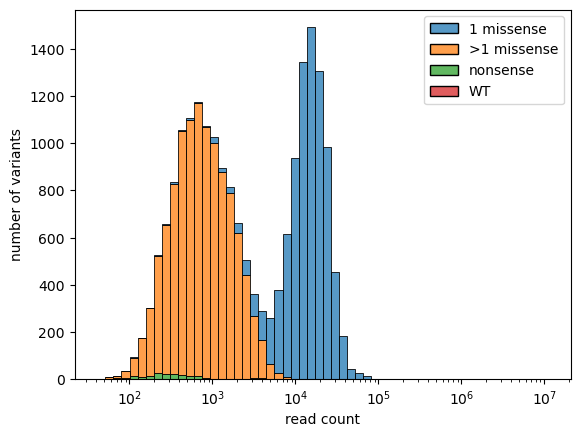

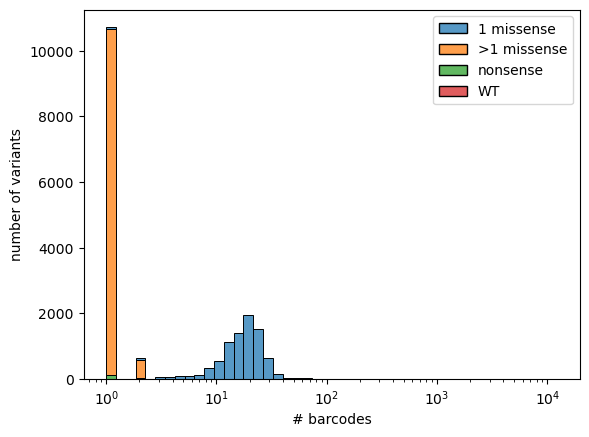

In [18]:
sns.histplot(x=Y.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("read count")
plt.ylabel("number of variants")
plt.show()
# plt.savefig(f"{output}/variant_read_counts_before_filter_hist.pdf")

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()
# plt.savefig(f"{output}/variant_n_barcodes_before_filter_hist.pdf")

## Filter variants with low read counts

We sum the read counts for each variant across all bins and concentrations, then proceed to filter out variants where this sum of counts is < 100

In [19]:
filter_idxs = (Y.sum((1, 2)) >= config['min_Titeseq_reads_per_variant'])
Y = Y[filter_idxs]
Ynorm = Ynorm[filter_idxs]
libs = libs[filter_idxs]
variants = variants[filter_idxs]
variant_types = variant_types[filter_idxs]
n_aa_substitutions = n_aa_substitutions[filter_idxs]
bcs = bcs[filter_idxs]

Y.shape

(19579, 9, 4)

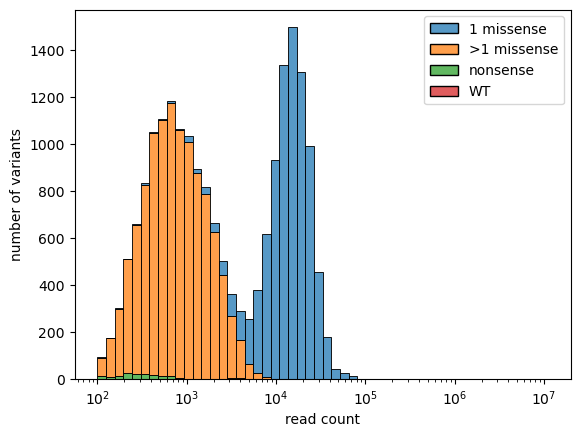

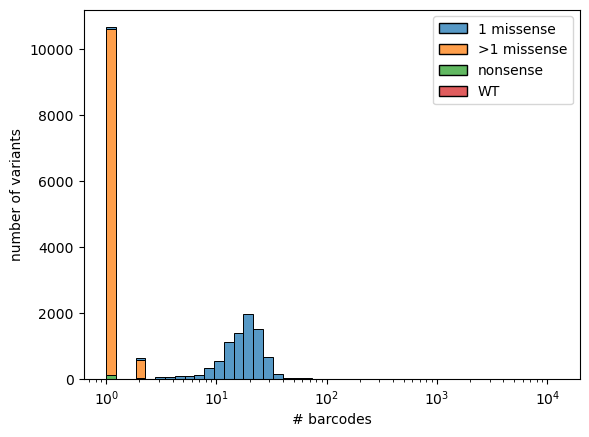

In [20]:
sns.histplot(x=Y.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

## modeling

indices of WT

In [21]:
wt_idx1, wt_idx2 = np.where(variants == "WT")[0]

libs[wt_idx1], variants[wt_idx1], libs[wt_idx2], variants[wt_idx2]

('lib1', 'WT', 'lib2', 'WT')

indices of libraries

In [22]:
lib1_idxs = np.where(libs == "lib1")[0]
lib2_idxs = np.where(libs == "lib2")[0]

Initialize parameters

In [23]:
def binfs_fn(df):
    result = pd.Series([np.log(df["PE-A"].loc[df["PE-A"] < b[1]]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[1]) & (df["PE-A"] < b[2])]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[2]) & (df["PE-A"] < b[3])]).mean(),
            np.log(df["PE-A"].loc[df["PE-A"] >= b[3]]).mean()],
            index=bins,
    )
    if pd.isna(result[1]):
        result[1] = np.log(b[1] / 2)
    if pd.isna(result[2]):
        result[2] = np.log(b[1] + (b[2] - b[1]) / 2)
    if pd.isna(result[3]):
        result[3] = np.log(b[2] + (b[3] - b[2]) / 2)
    if pd.isna(result[4]):
        result[4] = np.log(b[3] + (b[4] - b[3]) / 2)
    return result

binfs1 = fcs_df.query("library == 1").groupby("concentration").apply(binfs_fn).values
binfs2 = fcs_df.query("library == 2").groupby("concentration").apply(binfs_fn).values
binfs1, binfs2

(array([[ 3.67535567,  5.1029518 ,  8.84928666, 11.88986763],
        [ 3.8027649 ,  5.1255578 ,  9.66208456, 11.88986763],
        [ 3.96695796,  5.30006393,  7.83393444, 11.88986763],
        [ 4.05794371,  6.20638973,  8.06921064, 11.88986763],
        [ 4.21443269,  6.43628639,  8.79475605, 10.65593872],
        [ 3.94763998,  6.44813809,  9.27926545, 10.86366992],
        [ 3.96291979,  6.51484936,  9.23536877, 11.27990724],
        [ 4.02359372,  6.66549913,  9.19591443, 11.62314663],
        [ 3.56925577,  7.00021358,  9.3050182 , 11.68026997]]),
 array([[ 3.70144604,  5.10336554,  9.66208456, 11.88986763],
        [ 3.74420994,  5.12493838,  9.66208456, 11.88986763],
        [ 3.97271008,  5.27766209,  7.74602864, 11.88986763],
        [ 4.08805716,  6.20576978,  8.07307964, 11.88986763],
        [ 4.25937259,  6.39374475,  8.83492159, 10.65256475],
        [ 3.97367315,  6.43588833,  9.22710318, 10.87296893],
        [ 3.95195404,  6.52715668,  9.21514817, 11.30047172],
      

In [24]:
def mean_bin_fn(df):
    library = df.library.unique().squeeze()
    if library == "lib1":
        binfs = binfs1
    elif library == "lib2":
        binfs = binfs2
    else:
        raise ValueError(library)
    concentration = df.antigen_concentration.unique().squeeze()
    concentration_idx = np.where(x == concentration)[0].squeeze()
    return np.exp(np.average(binfs[concentration_idx], weights=df.estimated_cell_count))

mean_bin_variants = (
    df_variants
    .groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration"]) # TODO remove after development
    .apply(mean_bin_fn)
    .to_frame()
    .reset_index()
    .rename(columns={0: "bin_based_fluorescence"})
)

display(mean_bin_variants)

,library,variant,n_aa_substitutions,antigen_concentration,bin_based_fluorescence
0,lib1,A104C,1,0.000000e+00,40.549975
1,lib1,A104C,1,1.000000e-13,46.202822
2,lib1,A104C,1,1.000000e-12,64.519605
3,lib1,A104C,1,1.000000e-11,437.686913
4,lib1,A104C,1,1.000000e-10,5156.312588
...,...,...,...,...,...
176728,lib2,Y94W R145M,2,1.000000e-10,598.092095
176729,lib2,Y94W R145M,2,1.000000e-09,14580.818394
176730,lib2,Y94W R145M,2,1.000000e-08,23880.507519
176731,lib2,Y94W R145M,2,1.000000e-07,52046.775140


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


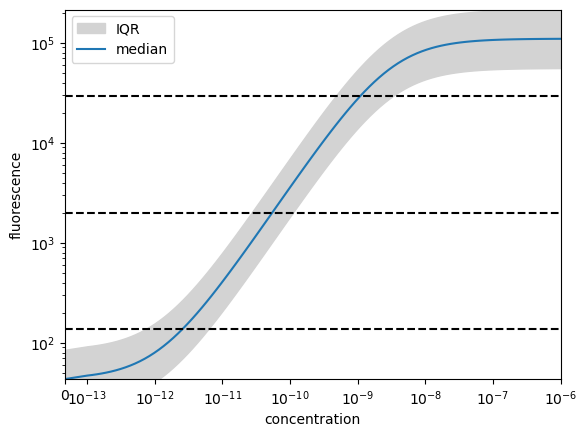

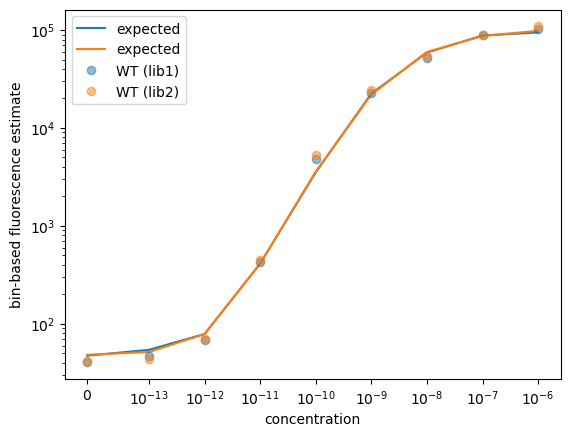

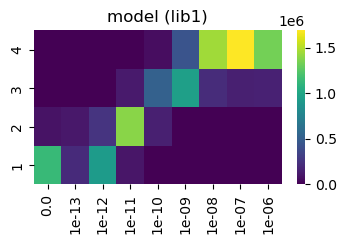

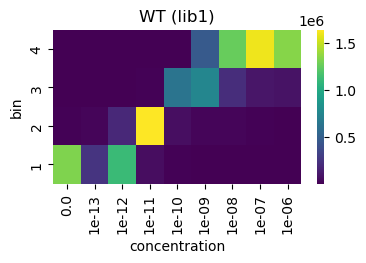

In [25]:
logα = np.log(1.1e5)
logKd = np.log(3e-9)
logσ = 0.0
logn = 0.0

logβ = np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].median())

logγ = np.log(bcs[wt_idx1] / bcs[lib1_idxs].sum())

x_grid = np.array([0] + list(np.logspace(np.log10(x[1]), np.log10(x[-1]), 100)))
logx_grid = np.log(x_grid)
fs = f(logx_grid, logα, logβ, logKd, logn)
scale = np.exp(logσ)
q25 = scipy.stats.lognorm.ppf(0.25, s=scale, scale=fs)
q75 = scipy.stats.lognorm.ppf(0.75, s=scale, scale=fs)
plt.fill_between(x_grid,
                 q25,
                 q75,
                 color="lightgray",
                 label="IQR")
plt.plot(x_grid, fs, label="median")
for b_ in b:
    plt.axhline(b_, color="k", linestyle="--")
plt.xscale("symlog", linthresh=x[1], linscale=0.3)
plt.yscale("log")
plt.ylim(b[0], b[-1])
plt.xlabel("concentration")
plt.ylabel("fluorescence")
plt.xlim(x[0], x[-1])
plt.ylim(fs[0], q75[-1])
plt.legend()
plt.show()
# plt.savefig(f"{output}/model_median_iqr_line.pdf")

ps = p(logx, logα, logβ, logKd, b, logσ, logn)
mean_binf1 = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf2 = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt1 = np.exp((binfs1 * Ynorm[wt_idx1]).sum(1) / Ynorm[wt_idx1].sum(1))
mean_binf_wt2 = np.exp((binfs2 * Ynorm[wt_idx2]).sum(1) / Ynorm[wt_idx2].sum(1))

plt.plot(x, mean_binf1, label="expected", c="C0")
plt.plot(x, mean_binf2, label="expected", c="C1")
plt.plot(x, mean_binf_wt1, "o", label="WT (lib1)", alpha=0.5, c="C0")
plt.plot(x, mean_binf_wt2, "o", label="WT (lib2)", alpha=0.5, c="C1")
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()
# plt.savefig(f"{output}/bin_based_fluorescence_estimate_line.pdf")

logps = logp(logx, logα, logβ, logKd, b, logσ, logn)

# expected read count matrix
exp_cell_df = pd.DataFrame((reads_per_cell1 * cells1.values.sum(1, keepdims=True) * np.exp(logγ + logps)).T, columns=x, index=bins)
plt.figure(figsize=(4, 2))
ax = sns.heatmap(exp_cell_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"model (lib1)")
plt.show()
# plt.savefig(f"{output}/model_lib1_expected_counts_heatmap.pdf")

read_df = pd.DataFrame(Y[wt_idx1].T, columns=pd.Series(x, name="concentration"), index=pd.Series(bins, name="bin"))
plt.figure(figsize=(4, 2))
ax = sns.heatmap(read_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"WT (lib1)")
plt.show()
# plt.savefig(f"{output}/WT_lib1_read_counts_heatmap.pdf")

Loss surface for WT

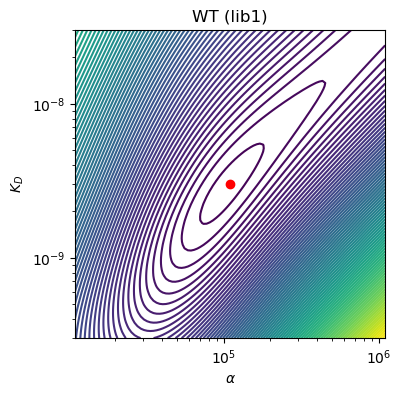

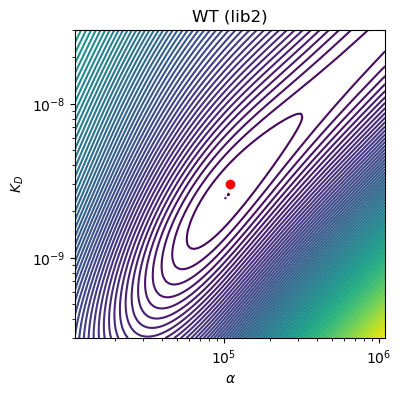

In [26]:
for ct, (wt_idx, logf_pdfs, binfs) in enumerate(zip((wt_idx1, wt_idx2),
                                                    (logf_pdfs1, logf_pdfs2),
                                                    (binfs1, binfs2)),
                                                          1):
    # plot loss surface for Kd and α on one sample
    αs = np.exp(logα) * np.logspace(-1, 1, 100)
    Kds = np.exp(logKd) * np.logspace(-1, 1, 100)
    # αs, Kds = np.meshgrid(αs, Kds)
    loss = np.zeros((Kds.shape[0], αs.shape[0]))
    for i in range(Kds.shape[0]):
        for j in range(αs.shape[0]):
            loss[i, j] = one_neg_log_likelihood(logγ, np.log(αs[j]), np.log(Kds[i]), Y[wt_idx],
                                                logβ, logσ, logx, b, cells1.values, reads_per_cell1.values, logn)

    plt.figure(figsize=(4, 4))
    plt.contour(αs, Kds, loss, levels=100)
    plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
    plt.xlabel("$\\alpha$")
    plt.ylabel("$K_D$")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"WT (lib{ct})")
    plt.show()

Form data and params for optimizations

In [27]:
single_mut_idxs = (n_aa_substitutions == 1) & (variant_types != "nonsense")
other_mut_idxs = (n_aa_substitutions > 1) | (variant_types == "nonsense")
assert sum(single_mut_idxs) + sum(other_mut_idxs) == len(n_aa_substitutions) - 2

In [28]:
data1 = Y[lib1_idxs], wt_idx1, logx, b, cells1.values.sum(1), reads_per_cell1.values, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"]).median(), logf_grid, logf_pdfs1, np.where(single_mut_idxs[lib1_idxs])[0], np.where(other_mut_idxs[lib1_idxs])[0]
data2 = Y[lib2_idxs], wt_idx2 - len(lib1_idxs), logx, b, cells2.values.sum(1), reads_per_cell2.values, np.log(fcs_df.query("library == 2 & concentration == 0")["PE-A"]).median(), logf_grid, logf_pdfs2, np.where(single_mut_idxs[lib2_idxs])[0], np.where(other_mut_idxs[lib2_idxs])[0]

$$
p(z\mid \alpha, \beta, K_D, \sigma^2)
$$

$$
\begin{align*}
p(\alpha, \beta, \gamma, \kappa, \sigma, Z, Y) &= p(\alpha, \beta, \gamma, \kappa, \sigma \mid Z, Y) \ p(Z, Y)\\
&= p(\alpha, \beta, \gamma, \kappa, \sigma \mid z, y) \ p(Y \mid Z) p(Z)
\end{align*}
$$

In [29]:
opt = jaxopt.ScipyBoundedMinimize(
    fun=neg_log_likelihood,
    method="l-bfgs-b",
    maxiter=1000, # 1000
    tol=1e-12,
    options=dict(
        maxls=100, # 100
        maxcor=10000, # 10000
    ),
    jit=True,
)

In [30]:
params1 = [jnp.log(bcs[lib1_idxs] / bcs[lib1_idxs].sum()),
           logα * jnp.ones(len(lib1_idxs)),
           logKd * jnp.ones(len(lib1_idxs)),
           jnp.asarray(logσ),
           jnp.asarray(logn),
           ]
params2 = [jnp.log(bcs[lib2_idxs] / bcs[lib2_idxs].sum()),
           logα * jnp.ones(len(lib2_idxs)),
           logKd * jnp.ones(len(lib2_idxs)),
           jnp.asarray(logσ),
           jnp.asarray(logn),
           ]

In [31]:
def bounds(params):
    lb = [
          jnp.full_like(params[0], -20),
          jnp.full_like(params[1], logα - 6),
          jnp.full_like(params[2], jnp.log(1e-12)),
          jnp.array(-0.75),
          jnp.array(-1.0),
          ]
    ub = [
          jnp.full_like(params[0], 0),
          jnp.full_like(params[1], logα + 6),
          jnp.full_like(params[2], jnp.log(1e-4)),
          jnp.array(0.75),
          jnp.array(1.0),
          ]
    return lb, ub

In [32]:
jax.grad(neg_log_likelihood)(params1, data1)

[Array([ 0.13800325,  0.02854429,  0.03538212, ..., -0.02237178,
        -0.01040843,  0.01130199], dtype=float64),
 Array([ 0.01480831,  0.00826123, -0.00047431, ...,  0.0157057 ,
        -0.00300895,  0.23824267], dtype=float64),
 Array([-0.01466567, -0.00454132, -0.00091075, ..., -0.0107503 ,
         0.00331897, -0.17355083], dtype=float64),
 Array(27.27801444, dtype=float64, weak_type=True),
 Array(-1029.74222251, dtype=float64, weak_type=True)]

In [33]:
γ_ridge = 1e-2
α_ridge = 1e-3
Kd_ridge = 1e-3

λ1 = 1e-3
λ2 = 1e-3
for μ in np.logspace(-2, 2, 10): # 10
    print(f"{μ=:.1e}", flush=True)
    print(f"  {λ1=:.1e}")
    params1, state1 = opt.run(
        params1,
        bounds(params1),
        data1,
        μ=μ, λ=λ1,
        γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge,
        )
    D1 = DKL(params1, data1)
    λ1 += μ * D1
    error1 = opt.l2_optimality_error(params1,
                                     bounds(params1),
                                     data1, μ=μ, λ=λ1, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    obj1 = neg_log_likelihood(params1, data1, μ=μ, λ=λ1, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    print(f"    {state1.iter_num} iterations, success={state1.success}")
    print(f"    error={error1:.2e}")
    print(f"    obj={obj1:.2e}")
    print(f"    DKL={D1:.2e}")

    print(f"  {λ2=:.1e}")
    params2, state2 = opt.run(
        params2,
        bounds(params2),
        data2,
        μ=μ, λ=λ2,
        γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge,
        )
    D2 = DKL(params2, data2)
    λ2 += μ * D2
    error2 = opt.l2_optimality_error(params2,
                                     bounds(params2),
                                     data2, μ=μ, λ=λ2, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    obj2 = neg_log_likelihood(params2, data2, μ=μ, λ=λ2, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    print(f"    {state2.iter_num} iterations, success={state2.success}")
    print(f"    error={error2:.2e}")
    print(f"    obj={obj2:.2e}")
    print(f"    DKL={D2:.2e}")

μ=1.0e-02


  λ1=1.0e-03


    725 iterations, success=True
    error=3.53e-02
    obj=-7.18e+04
    DKL=1.12e+00
  λ2=1.0e-03


    626 iterations, success=True
    error=6.89e-02
    obj=-5.00e+04
    DKL=1.64e+00
μ=2.8e-02


  λ1=1.2e-02


    4 iterations, success=True
    error=9.80e-02
    obj=-7.18e+04
    DKL=1.12e+00
  λ2=1.7e-02


    130 iterations, success=True
    error=1.88e-01
    obj=-5.00e+04
    DKL=1.63e+00
μ=7.7e-02


  λ1=4.3e-02


    5 iterations, success=True
    error=2.86e-01
    obj=-7.18e+04
    DKL=1.12e+00
  λ2=6.3e-02


    105 iterations, success=True
    error=5.20e-01
    obj=-5.00e+04
    DKL=1.63e+00
μ=2.2e-01


  λ1=1.3e-01


    227 iterations, success=True
    error=7.46e-01
    obj=-7.18e+04
    DKL=1.11e+00
  λ2=1.9e-01


    372 iterations, success=True
    error=1.39e+00
    obj=-5.00e+04
    DKL=1.60e+00
μ=6.0e-01


  λ1=3.7e-01


    147 iterations, success=True
    error=1.44e+00
    obj=-7.18e+04
    DKL=1.09e+00
  λ2=5.3e-01


    680 iterations, success=True
    error=1.57e+00
    obj=-5.00e+04
    DKL=1.54e+00
μ=1.7e+00


  λ1=1.0e+00


    627 iterations, success=True
    error=1.48e+00
    obj=-7.18e+04
    DKL=1.04e+00
  λ2=1.5e+00


    755 iterations, success=True
    error=1.56e+00
    obj=-5.00e+04
    DKL=1.41e+00
μ=4.6e+00


  λ1=2.8e+00


    467 iterations, success=True
    error=1.48e+00
    obj=-7.18e+04
    DKL=9.45e-01
  λ2=3.8e+00


    567 iterations, success=True
    error=1.55e+00
    obj=-5.00e+04
    DKL=1.21e+00
μ=1.3e+01


  λ1=7.1e+00


    722 iterations, success=True
    error=1.48e+00
    obj=-7.18e+04
    DKL=8.12e-01
  λ2=9.4e+00


    713 iterations, success=True
    error=1.54e+00
    obj=-5.00e+04
    DKL=9.76e-01
μ=3.6e+01


  λ1=1.8e+01


    889 iterations, success=True
    error=1.48e+00
    obj=-7.17e+04
    DKL=6.69e-01
  λ2=2.2e+01


    812 iterations, success=True
    error=1.53e+00
    obj=-4.99e+04
    DKL=7.73e-01
μ=1.0e+02


  λ1=4.2e+01


    705 iterations, success=True
    error=1.49e+00
    obj=-7.17e+04
    DKL=5.56e-01
  λ2=5.0e+01


    878 iterations, success=True
    error=1.52e+00
    obj=-4.99e+04
    DKL=6.39e-01


In [34]:
params1, params2

([Array([ -8.36468334, -12.01288156, -12.09358096, ..., -10.84783101,
         -11.26084972,  -7.8638363 ], dtype=float64),
  Array([11.35459483, 11.79655185, 12.04083282, ..., 11.24829297,
         11.80022826, 11.12104811], dtype=float64),
  Array([-19.97584456, -19.69092641, -19.86175753, ..., -18.57577271,
         -20.10492621, -19.51776902], dtype=float64),
  Array(-0.25072091, dtype=float64),
  Array(0.01446219, dtype=float64)],
 [Array([ -8.73026179,  -8.02059392, -12.09844065, ..., -11.4876509 ,
          -7.43227149, -11.95294006], dtype=float64),
  Array([11.39194604, 11.2257422 , 12.06556082, ..., 12.1163389 ,
         11.11624492, 11.88817798], dtype=float64),
  Array([-19.9809246 , -19.63245899, -19.91183776, ..., -20.37965586,
         -19.66547778, -19.94929061], dtype=float64),
  Array(-0.291543, dtype=float64),
  Array(0.02309911, dtype=float64)])

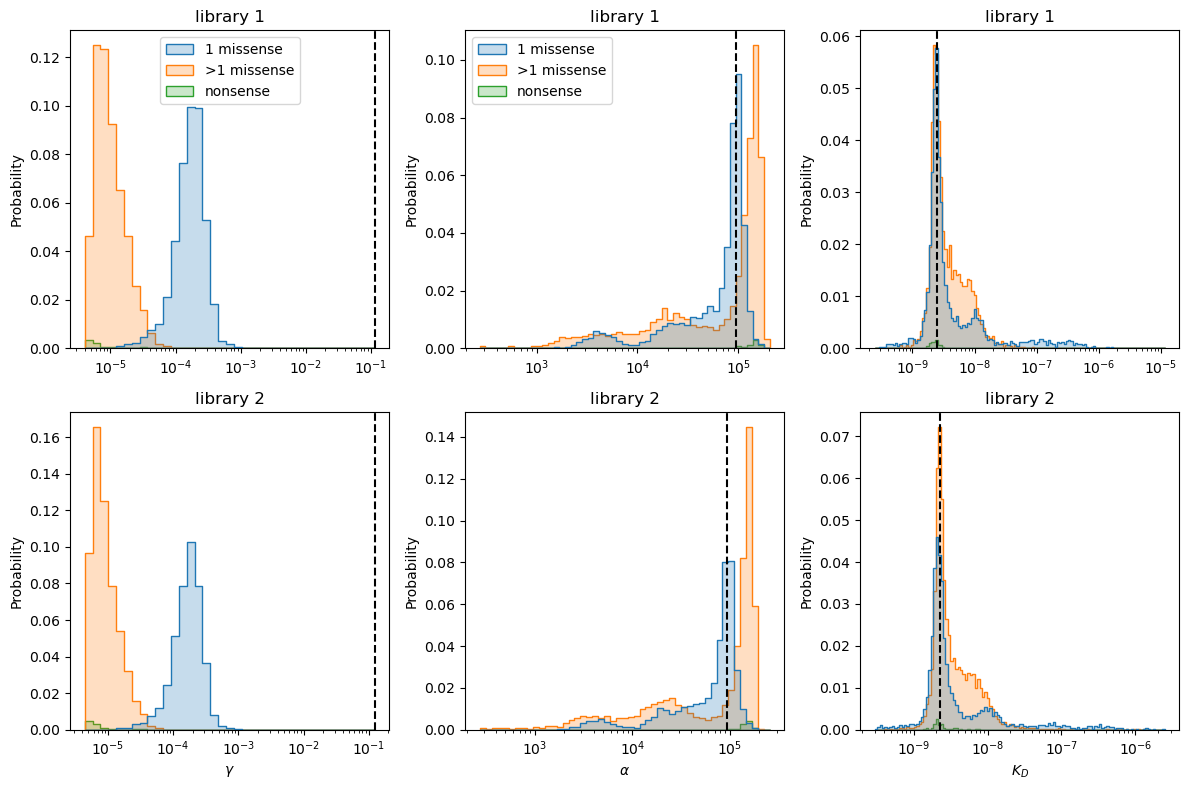

In [35]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
sns.histplot(x=np.exp(params1[0]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             )
plt.axvline(np.exp(params1[0][wt_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(234)
sns.histplot(x=np.exp(params2[0]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[0][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\gamma$")
plt.subplot(232)
sns.histplot(x=np.exp(params1[1]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
             element="step",
             )
plt.axvline(np.exp(params1[1][wt_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(235)
sns.histplot(x=np.exp(params2[1]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[1][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\alpha$")
plt.subplot(233)
sns.histplot(x=np.exp(params1[2]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
             element="step",
             legend=False,
             )
plt.title("library 1")
plt.axvline(np.exp(params1[2][wt_idx1]), color="k", linestyle="--")
plt.subplot(236)
sns.histplot(x=np.exp(params2[2]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[2][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$K_D$")
plt.tight_layout()
plt.show()

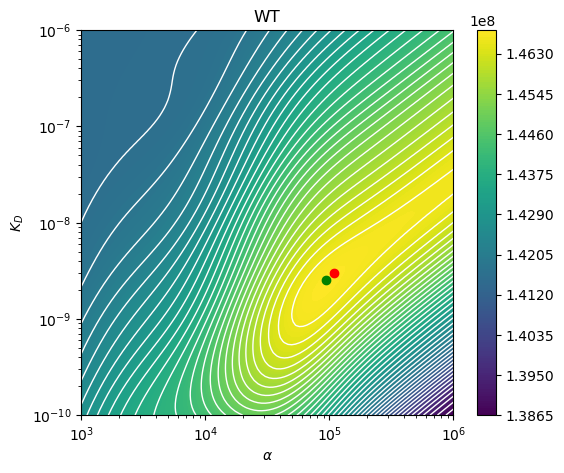

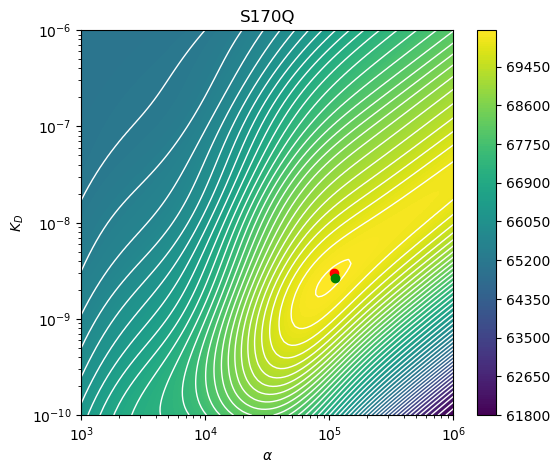

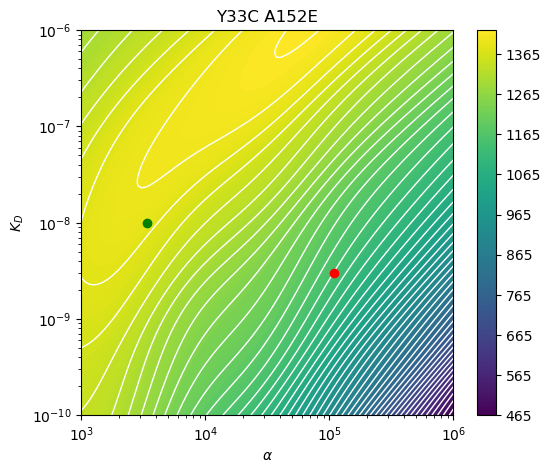

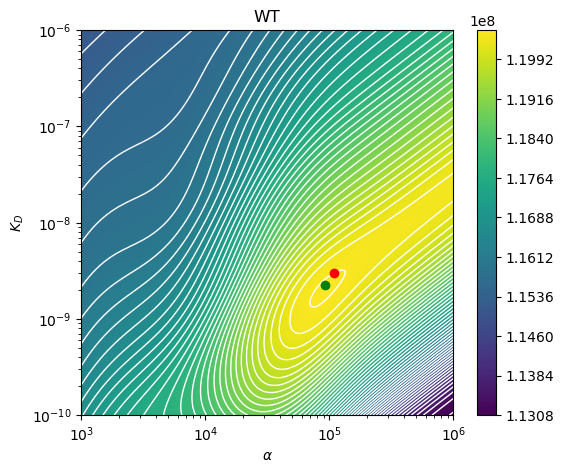

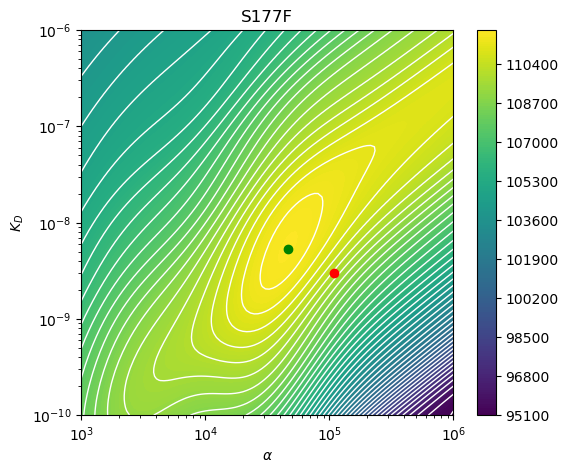

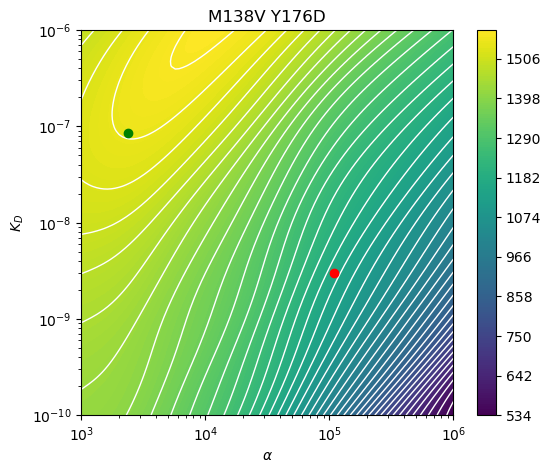

In [36]:
for datai, paramsi, wt_idxi, variantsi, variant_typesi in zip((data1, data2),
                                      (params1, params2),
                                      (wt_idx1, wt_idx2 - len(lib1_idxs)),
                                      (variants[lib1_idxs], variants[lib2_idxs]),
                                      (variant_types[lib1_idxs], variant_types[lib2_idxs]),
                                      ):
    Yi = datai[0].copy()
    logβi = datai[6]
    logγi = paramsi[0].copy()
    logσi = paramsi[3]
    logni = paramsi[4].copy()
    cellsi = datai[4].copy()
    reads_per_celli = datai[5].copy()
    αs = np.logspace(3, 6, 100)
    Kds = np.logspace(-10, -6, 100)
    for var_idx in (wt_idxi,
                    np.random.choice(np.where(variant_typesi == "1 missense")[0], 1)[0],
                    np.random.choice(np.where(variant_typesi == ">1 missense")[0], 1)[0]):
        # plot loss surface for Kd and α on one sample
        loss = np.zeros((Kds.shape[0], αs.shape[0]))
        for i in range(Kds.shape[0]):
            for j in range(αs.shape[0]):
                loss[i, j] = -one_neg_log_likelihood(logγi[var_idx], np.log(αs[j]), np.log(Kds[i]), Yi[var_idx],
                                                    logβi, logσi, logx, b, cellsi, reads_per_celli, logni)


        plt.figure(figsize=(6, 5))
        plt.contourf(αs, Kds, loss, levels=200, alpha=1.0)
        plt.colorbar()
        plt.contour(αs, Kds, loss, levels=50, linestyles="solid", linewidths=1, colors="w")
        plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
        plt.plot(np.exp(paramsi[1][var_idx]), np.exp(paramsi[2][var_idx]), "o", color="g")
        plt.xlabel("$\\alpha$")
        plt.ylabel("$K_D$")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(variantsi[var_idx])
        plt.show()

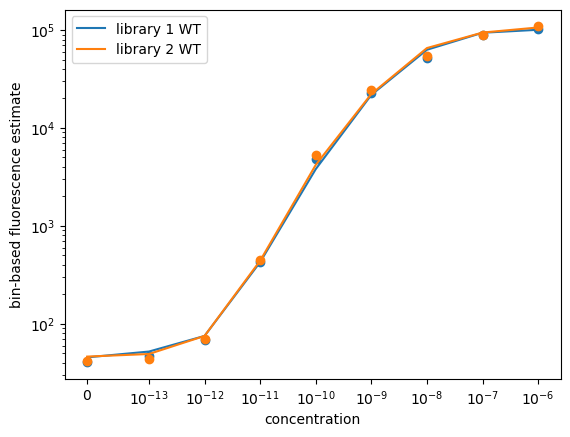

In [37]:
ps = p(logx, params1[1][wt_idx1], data1[6], params1[2][wt_idx1], b, params1[3], params1[4])
mean_binf = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs1 * Ynorm[wt_idx1]).sum(1) / Ynorm[wt_idx1].sum(1))
plt.plot(x, mean_binf, c="C0", label="library 1 WT")
plt.plot(x, mean_binf_wt, "o", c="C0")
ps = p(logx, params2[1][wt_idx2 - len(lib1_idxs)], data2[6], params2[2][wt_idx2 - len(lib1_idxs)], b, params2[3], params2[4])
mean_binf = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs2 * Ynorm[wt_idx2]).sum(1) / Ynorm[wt_idx2].sum(1))
plt.plot(x, mean_binf, c="C1", label="library 2 WT")
plt.plot(x, mean_binf_wt, "o", c="C1")
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

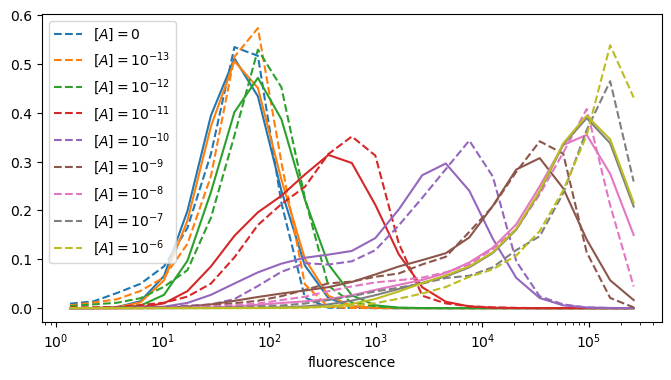

In [38]:
plt.figure(figsize=(8, 4))
for i, fs in enumerate(f(logx, params1[1], data1[6], params1[2], params1[4])):
    curve = scipy.stats.norm.pdf(logf_grid, loc=jnp.log(fs[:, None]), scale=np.exp(params1[3])).mean(0)
    curve = curve / jax.scipy.integrate.trapezoid(curve, x=logf_grid)
    plt.plot(np.exp(logf_grid), curve, c=f"C{i}")
    if i == 0:
        label = "$[A]=0$"
    else:
        label = f"$[A]=10^{{{int(np.log10(x[i])):1d}}}$"
    plt.plot(np.exp(logf_grid), logf_pdfs1[i], c=f"C{i}", ls="--", label=label)
plt.xscale("log")
plt.xlabel("fluorescence")
plt.legend()
plt.show()

In [39]:
variant_params_df = pd.DataFrame({"library": libs,
                            "variant": variants,
                            "n_aa_substitutions": n_aa_substitutions,
                            "variant_type": variant_types,
                            "n_bc_bind_CGG" : bcs, # number of unique barcodes for a given variant across the bins, and the antigen concentrations for a given variant
                            "sum_conc_bin_norm_count_bind_CGG": Ynorm.sum((1, 2)), # TODO, should this be summed? Is this even a useful stat to keep around? Tyler's original Kd had something called Titeseq_avgcount .. 
                            })
variant_params_df.loc[lib1_idxs, "log10fraction"] = np.asarray(params1[0]) / np.log(10)
variant_params_df.loc[lib2_idxs, "log10fraction"] = np.asarray(params2[0]) / np.log(10)
variant_params_df.loc[lib1_idxs, "log10expression"] = np.asarray(params1[1]) / np.log(10)
variant_params_df.loc[lib2_idxs, "log10expression"] = np.asarray(params2[1]) / np.log(10)
variant_params_df.loc[lib1_idxs, "log10Kd"] = np.array(params1[2]) / np.log(10)
variant_params_df.loc[lib2_idxs, "log10Kd"] = np.array(params2[2]) / np.log(10)

for lib in ("lib1", "lib2"):
    variant_params_df.loc[variant_params_df.library==lib, f"delta_log10Ka"] = variant_params_df.loc[(variant_params_df.library==lib) & (variant_params_df.variant=="WT"), "log10Kd"].squeeze() - variant_params_df.loc[variant_params_df.library==lib, "log10Kd"]

variant_params_df

,library,variant,n_aa_substitutions,variant_type,n_bc_bind_CGG,sum_conc_bin_norm_count_bind_CGG,log10fraction,log10expression,log10Kd,delta_log10Ka
0,lib1,A104C,1,1 missense,25.0,11274.942865,-3.632736,4.931238,-8.675399,0.074500
1,lib1,A104C A173E,2,>1 missense,1.0,244.956828,-5.217128,5.123177,-8.551661,-0.049238
2,lib1,A104C F137L,2,>1 missense,1.0,161.357423,-5.252175,5.229267,-8.625852,0.024953
3,lib1,A104C G105V,2,>1 missense,1.0,1014.580863,-4.779690,4.392416,-7.911355,-0.689544
4,lib1,A104C G118S,2,>1 missense,1.0,215.773565,-5.205832,5.176473,-8.630540,0.029641
...,...,...,...,...,...,...,...,...,...,...
19574,lib2,Y94V,1,1 missense,53.0,17243.956452,-3.443573,5.005695,-9.170133,0.524928
19575,lib2,Y94V G113C,2,>1 missense,1.0,1057.398194,-4.767220,5.117894,-8.820350,0.175145
19576,lib2,Y94V S112G,2,>1 missense,1.0,561.502696,-4.989023,5.262059,-8.850772,0.205566
19577,lib2,Y94W,1,1 missense,48.0,28360.862798,-3.227794,4.827724,-8.540608,-0.104597


In [40]:
variant_params_df.query("variant == 'WT'").log10Kd

8712    -8.600899
18798   -8.645206
Name: log10Kd, dtype: float64

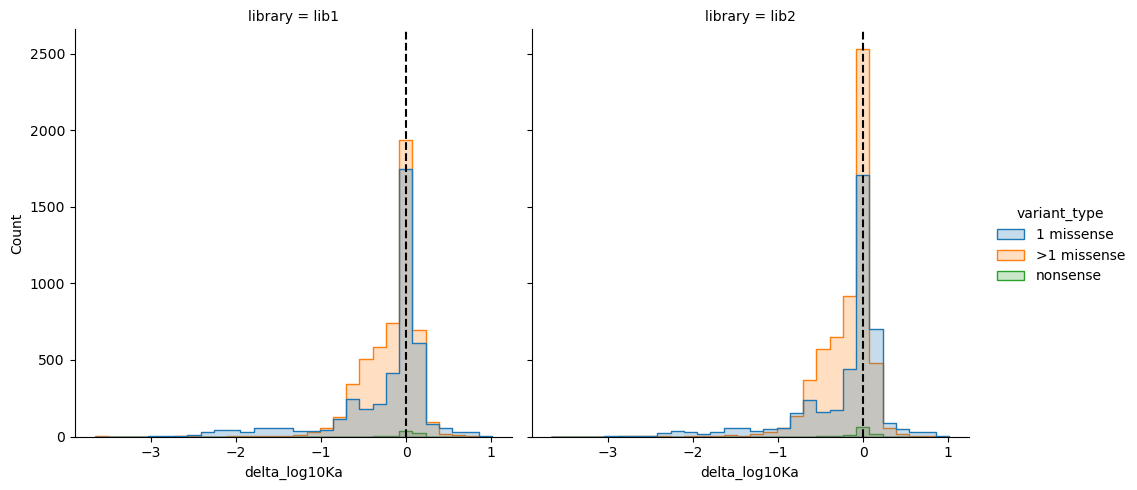

In [41]:
g = sns.displot(variant_params_df,
                x="delta_log10Ka", col="library", hue="variant_type",
                hue_order=("1 missense", ">1 missense", "nonsense"),
                bins=30,
                element="step"
                )
g.axes[0, 0].axvline(0, color="k", linestyle="--")
g.axes[0, 1].axvline(0, color="k", linestyle="--")
plt.show()

Show some titration curve fits

In [42]:
plot_variants = pd.Series([
                           "F225D",
                           "Y176T",
                           "V160D",
                           "I129H",
                           "Q16W",
                           "L4T",
                           ])
plot_variants

0    F225D
1    Y176T
2    V160D
3    I129H
4     Q16W
5      L4T
dtype: object

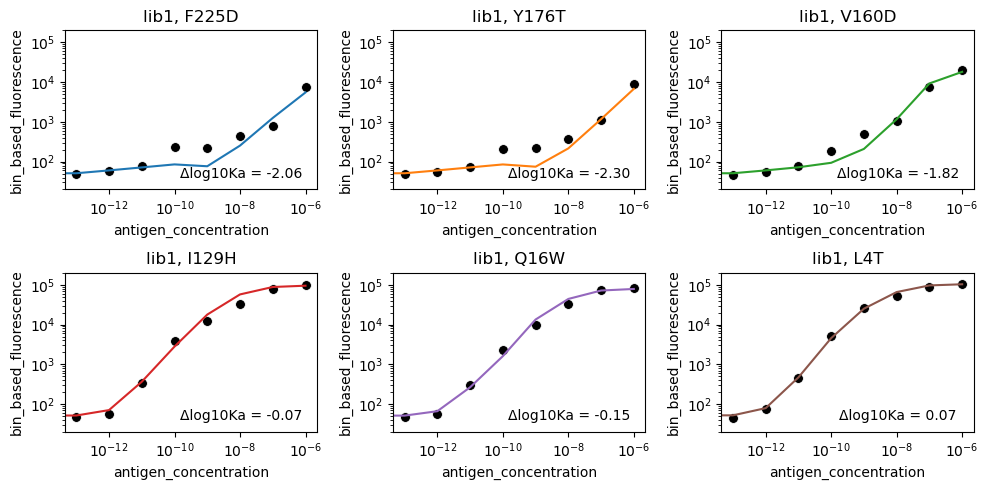

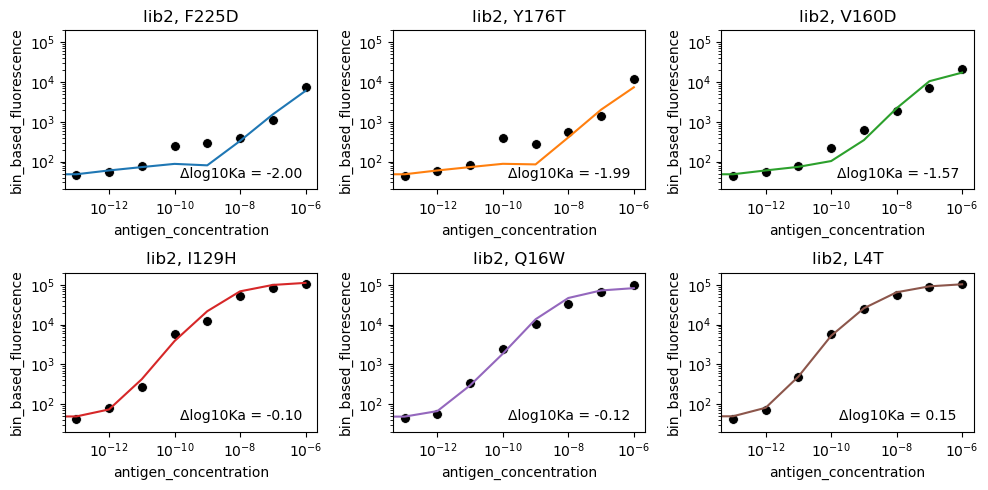

In [43]:
for library, params, data, lib_idxs in zip(
    ("lib1", "lib2"),
    (params1, params2),
    (data1, data2),
    (lib1_idxs, lib2_idxs),
    ):
    plt.figure(figsize=(10, 5))
    for i, variant in enumerate(plot_variants):
        plt.subplot(2, 3, i + 1)
        plt.title(f"{library}, {variant}")
        sns.scatterplot(data=mean_bin_variants.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence",
                    color="k", alpha=1.0,
                    s=50,
                    )
        plt.annotate(f"Δlog10Ka = {variant_params_df.query('(library == @library) & (variant == @variant)').delta_log10Ka.squeeze():.2f}",
                    xy=(0.7, 0.1), xycoords="axes fraction",
                    ha="center", va="center",
                    )
        variant_idx = list(variants[lib_idxs]).index(variant)
        ps = p(logx, params[1][variant_idx], data[6], params[2][variant_idx], b, params[3], params[4])
        if library == "lib1":
            binfs = binfs1
        elif library == "lib2":
            binfs = binfs2
        else:
            raise ValueError(library)
        mean_bins = np.exp((binfs * ps).sum(1) / ps.sum(1))
        plt.plot(x, mean_bins, color=f"C{i}")
        plt.ylim(20, 2e5)
        plt.xscale("log")
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

$\log_{10} K_A$ correlation

Number of variants: 15381


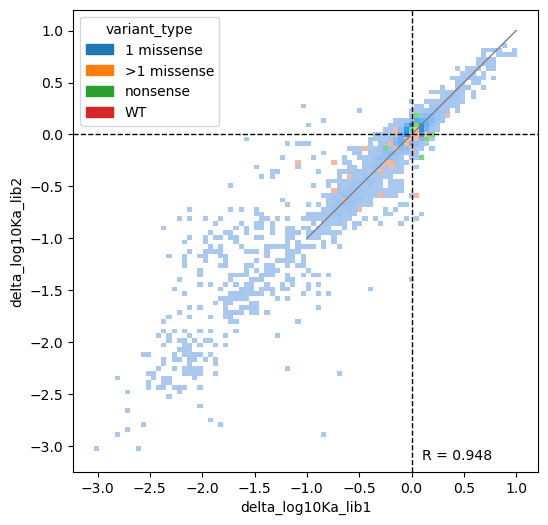

In [44]:
pivoted = variant_params_df.pivot(index="variant", columns="library")
print(f"Number of variants: {len(pivoted)}")
pivoted.columns = pivoted.columns.map("_".join)
pivoted.drop("variant_type_lib2", axis=1, inplace=True)
pivoted.rename(columns={"variant_type_lib1": "variant_type"}, inplace=True)
hist_bins = np.linspace(-2, 1, 100)
plt.figure(figsize=(6, 6))
sns.histplot(data=pivoted,
              x="delta_log10Ka_lib1",
              y="delta_log10Ka_lib2",
              hue="variant_type",
              )
pearson_cor_r = scipy.stats.pearsonr(*pivoted[['delta_log10Ka_lib1', 'delta_log10Ka_lib2']].dropna().values.T).statistic
plt.annotate(f"R = {pearson_cor_r:.3f}",
                (0.75, 0.05), xycoords="axes fraction", ha="left", va="top")
plt.plot([-1, 1], [-1, 1], color="gray", lw=1)
plt.axvline(0, color="black", lw=1, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
plt.show()

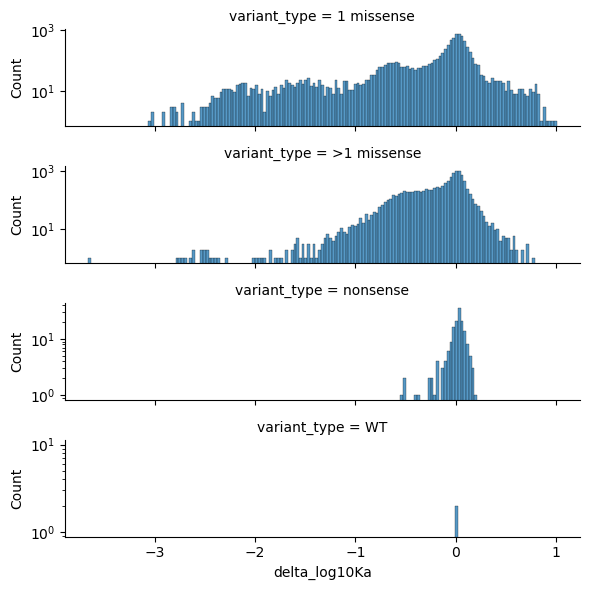

In [45]:
sns.displot(data=variant_params_df,
             x="delta_log10Ka", row="variant_type",
             multiple="stack",
             common_norm=False, facet_kws=dict(sharey=False),
             log=True,
             height=1.5, aspect=4)      
plt.show()

### IMGT numbering

In [46]:
pos_df = pd.read_csv(config['CGGnaive_site_info'], dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [47]:
def imgt_fn(variant):
    if variant == "WT":
        return "WT"
    muts = []
    for mut in variant.split(" "):
        wt = mut[0]
        site_scFv = int(mut[1:-1])
        site_imgt = pos_df.site[site_scFv]
        chain = pos_df.chain[site_scFv]
        mut = mut[-1]
        muts.append(f"{wt}{site_imgt}({chain}){mut}")
    return " ".join(muts)

In [48]:
variant_params_df["variant_imgt"] = variant_params_df.variant.apply(imgt_fn)
variant_params_df

,library,variant,n_aa_substitutions,variant_type,n_bc_bind_CGG,sum_conc_bin_norm_count_bind_CGG,log10fraction,log10expression,log10Kd,delta_log10Ka,variant_imgt
0,lib1,A104C,1,1 missense,25.0,11274.942865,-3.632736,4.931238,-8.675399,0.074500,A120(H)C
1,lib1,A104C A173E,2,>1 missense,1.0,244.956828,-5.217128,5.123177,-8.551661,-0.049238,A120(H)C A52(L)E
2,lib1,A104C F137L,2,>1 missense,1.0,161.357423,-5.252175,5.229267,-8.625852,0.024953,A120(H)C F10(L)L
3,lib1,A104C G105V,2,>1 missense,1.0,1014.580863,-4.779690,4.392416,-7.911355,-0.689544,A120(H)C G121(H)V
4,lib1,A104C G118S,2,>1 missense,1.0,215.773565,-5.205832,5.176473,-8.630540,0.029641,A120(H)C G<NA>(link)S
...,...,...,...,...,...,...,...,...,...,...,...
19574,lib2,Y94V,1,1 missense,53.0,17243.956452,-3.443573,5.005695,-9.170133,0.524928,Y103(H)V
19575,lib2,Y94V G113C,2,>1 missense,1.0,1057.398194,-4.767220,5.117894,-8.820350,0.175145,Y103(H)V G<NA>(link)C
19576,lib2,Y94V S112G,2,>1 missense,1.0,561.502696,-4.989023,5.262059,-8.850772,0.205566,Y103(H)V S128(H)G
19577,lib2,Y94W,1,1 missense,48.0,28360.862798,-3.227794,4.827724,-8.540608,-0.104597,Y103(H)W


In [49]:
variant_params_df.log10Kd = -variant_params_df.log10Kd


## Output
Rather than read in the old final variants table, we need to make the output have the following columns:

TODO: document these columns
- library	
- variant	
- n_aa_substitutions	
- variant_type	
- n_bc_bind_CGG	
- sum_conc_bin_norm_count_bind_CGG	
- log10fraction	
- log10expression	
- log10Kd	
- delta_log10Ka	
- variant_imgt

In [50]:
variant_params_df.head()

,library,variant,n_aa_substitutions,variant_type,n_bc_bind_CGG,sum_conc_bin_norm_count_bind_CGG,log10fraction,log10expression,log10Kd,delta_log10Ka,variant_imgt
0,lib1,A104C,1,1 missense,25.0,11274.942865,-3.632736,4.931238,8.675399,0.074500,A120(H)C
1,lib1,A104C A173E,2,>1 missense,1.0,244.956828,-5.217128,5.123177,8.551661,-0.049238,A120(H)C A52(L)E
2,lib1,A104C F137L,2,>1 missense,1.0,161.357423,-5.252175,5.229267,8.625852,0.024953,A120(H)C F10(L)L
3,lib1,A104C G105V,2,>1 missense,1.0,1014.580863,-4.779690,4.392416,7.911355,-0.689544,A120(H)C G121(H)V
4,lib1,A104C G118S,2,>1 missense,1.0,215.773565,-5.205832,5.176473,8.630540,0.029641,A120(H)C G<NA>(link)S


In [51]:
ret = (
    variant_params_df
    .assign(target='CGG_naive')
    .rename(
        columns={
            "variant":"aa_substitutions",
            "variant_type" : "variant_class",
            "log10Kd" : "bind_CGG",
            "delta_log10Ka": "delta_bind_CGG",
            "log10fraction": "log10fraction_titeseq",
            "log10expression": "log10expression_titeseq"
        }
    )
    [["library", "target", "variant_class", "aa_substitutions", "variant_imgt", "n_aa_substitutions", "n_bc_bind_CGG", "sum_conc_bin_norm_count_bind_CGG", "bind_CGG", "delta_bind_CGG", "log10fraction_titeseq", "log10expression_titeseq"]]
)

rename_class_dict = {
    "WT" : "wildtype",
    "1 missense" : "1 nonsynonymous",
    ">1 missense" : ">1 nonsynonymous",
    "nonsense" : "stop" 
}

ret.variant_class = ret.variant_class.replace(rename_class_dict)

In [52]:
ret

,library,target,variant_class,aa_substitutions,variant_imgt,n_aa_substitutions,n_bc_bind_CGG,sum_conc_bin_norm_count_bind_CGG,bind_CGG,delta_bind_CGG,log10fraction_titeseq,log10expression_titeseq
0,lib1,CGG_naive,1 nonsynonymous,A104C,A120(H)C,1,25.0,11274.942865,8.675399,0.074500,-3.632736,4.931238
1,lib1,CGG_naive,>1 nonsynonymous,A104C A173E,A120(H)C A52(L)E,2,1.0,244.956828,8.551661,-0.049238,-5.217128,5.123177
2,lib1,CGG_naive,>1 nonsynonymous,A104C F137L,A120(H)C F10(L)L,2,1.0,161.357423,8.625852,0.024953,-5.252175,5.229267
3,lib1,CGG_naive,>1 nonsynonymous,A104C G105V,A120(H)C G121(H)V,2,1.0,1014.580863,7.911355,-0.689544,-4.779690,4.392416
4,lib1,CGG_naive,>1 nonsynonymous,A104C G118S,A120(H)C G<NA>(link)S,2,1.0,215.773565,8.630540,0.029641,-5.205832,5.176473
...,...,...,...,...,...,...,...,...,...,...,...,...
19574,lib2,CGG_naive,1 nonsynonymous,Y94V,Y103(H)V,1,53.0,17243.956452,9.170133,0.524928,-3.443573,5.005695
19575,lib2,CGG_naive,>1 nonsynonymous,Y94V G113C,Y103(H)V G<NA>(link)C,2,1.0,1057.398194,8.820350,0.175145,-4.767220,5.117894
19576,lib2,CGG_naive,>1 nonsynonymous,Y94V S112G,Y103(H)V S128(H)G,2,1.0,561.502696,8.850772,0.205566,-4.989023,5.262059
19577,lib2,CGG_naive,1 nonsynonymous,Y94W,Y103(H)W,1,48.0,28360.862798,8.540608,-0.104597,-3.227794,4.827724


In [53]:
if not os.path.exists(config["Titeseq_Kds_dir"]):
    os.makedirs(config["Titeseq_Kds_dir"])


ret.to_csv(config['Titeseq_Kds_file'], index=False)